# Face Recognition using face embeddings

Facenet model is used extract face embeddings which is current state of the art model for face recognition. This model is based on resnet architecture

In [4]:
!pip install onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 66.3 MB/s eta 0:00:00


In [5]:
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
import os
import time

In [6]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

/home/easgrad/ninadnar/miniconda3/envs/bio1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
directory = 'VIDTIMIT'  # Replace with the path to your directory

labels = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

mtcnn = MTCNN()
resnet = InceptionResnetV1(pretrained='vggface2').eval()
print("Total Persons : ", len(labels))

Total Persons :  43


# Store Embeddings for all faces

frontal face is used to store embeddings

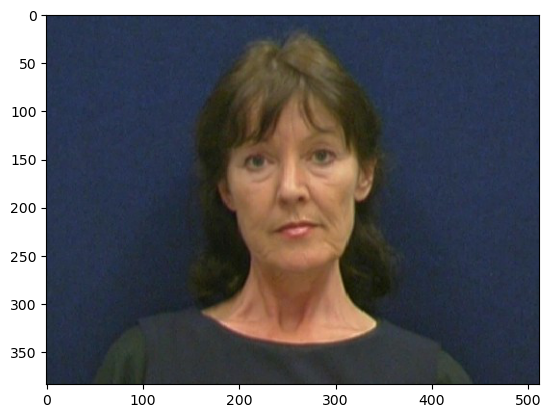

In [14]:
img = "fadg0"
img_path = f"{directory}/{img}/video/head3/004"
img = Image.open(img_path)
plt.imshow(img)

## Facenet

In [15]:
embeddings = {}

for label in labels:
    face_path = f"{directory}/{label}/video/head3/004"
    img = Image.open(face_path)
    img_cropped = mtcnn(img)
    
    try:
        img_embedding = resnet(img_cropped.unsqueeze(0))
    except:
        print(img_cropped, label, img)
        plt.imshow(img)
        break
    
    embeddings[label] = img_embedding
    

## Arcface

In [17]:
app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

handler = insightface.model_zoo.get_model('buffalo_l')
handler.prepare(ctx_id=0)

2023-07-25 18:36:43.945318696 [E:onnxruntime:, inference_session.cc:1644 operator()] Exception during initialization: /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, ERRTYPE, const char*, const char*, int) [with ERRTYPE = cublasStatus_t; bool THRW = true; std::conditional_t<THRW, void, onnxruntime::common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:114 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, ERRTYPE, const char*, const char*, int) [with ERRTYPE = cublasStatus_t; bool THRW = true; std::conditional_t<THRW, void, onnxruntime::common::Status> = void] CUBLAS failure 3: CUBLAS_STATUS_ALLOC_FAILED ; GPU=0 ; hostname=trail-01 ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=164 ; expr=cublasCreate(&cublas_handl

RuntimeException: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Exception during initialization: /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, ERRTYPE, const char*, const char*, int) [with ERRTYPE = cublasStatus_t; bool THRW = true; std::conditional_t<THRW, void, onnxruntime::common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:114 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, ERRTYPE, const char*, const char*, int) [with ERRTYPE = cublasStatus_t; bool THRW = true; std::conditional_t<THRW, void, onnxruntime::common::Status> = void] CUBLAS failure 3: CUBLAS_STATUS_ALLOC_FAILED ; GPU=0 ; hostname=trail-01 ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=164 ; expr=cublasCreate(&cublas_handle_); 



In [18]:
arc_embeddings = {}

for label in labels:
    face_path = f"{directory}/{label}/video/head3/004"
    #img = Image.open(face_path)
    
    image = cv2.imread(face_path)
    faces = app.get(image)
    embd = handler.get(image, faces[0]) #resnet(img_crop.unsqueeze(0))
    
    arc_embeddings[label] = embd
    

/home/easgrad/ninadnar/miniconda3/envs/bio1/lib/python3.11/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


# Accuracy with frontal face

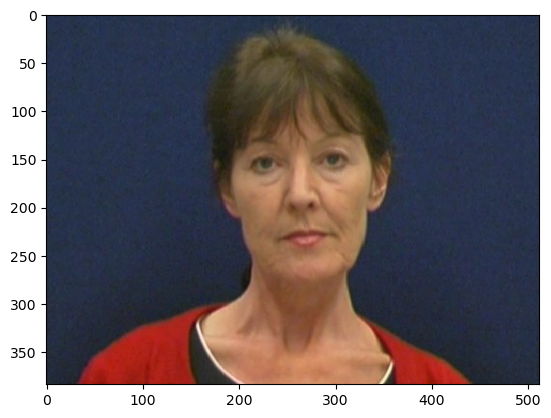

In [19]:
img = "fadg0"
img_path = f"{directory}/{img}/video/head2/001"
img = Image.open(img_path)
plt.imshow(img)

In [20]:
correct_detection_count = 0
for label in labels:
    
    # Extract Embedding for ground truth
    try:
        img_path = f"{directory}/{label}/video/head2/001"
        img = Image.open(img_path)
        img_cropped = mtcnn(img)
        img_embedding = resnet(img_cropped.unsqueeze(0))
        
        max_cos = torch.tensor([-1])
        closest_label = None
        
        for test_label, test_embedding in embeddings.items():
            cos_similarity = F.cosine_similarity(img_embedding, test_embedding)
            max_cos = torch.max(max_cos, cos_similarity)
            if max_cos == cos_similarity:
                closest_label = test_label
            
        if closest_label == label:
            correct_detection_count += 1
    except:
        print(label, " Error ")

accuracy = correct_detection_count/ 43
print("-"*50)
print("-"*50)
print("Accuracy is :" , accuracy*100 , "%" )  
print("-"*50)
print("-"*50) 
    

--------------------------------------------------
--------------------------------------------------
Accuracy is : 100.0 %
--------------------------------------------------
--------------------------------------------------


In [21]:
correct_detection_count = 0
for label in labels:
    
    # Extract Embedding for ground truth
    try:
        img_path = f"{directory}/{label}/video/head2/001"
        
        image = cv2.imread(img_path)
        #img_crop = mtcnn(image)
        faces = app.get(image)
        img_embedding = handler.get(image, faces[0])

        closest_label = None
        
        detected_p = None
        accu = -1
        for key, value in arc_embeddings.items():
            recog = handler.compute_sim(value, img_embedding )
            if recog > accu:
                detected_p = key
                accu = recog
        closest_label = detected_p
        
        if closest_label == label:
            correct_detection_count += 1
    except:
        print(label, " Error ")

accuracy = correct_detection_count/ 43
print("-"*50)
print("-"*50)
print("Accuracy is :" , accuracy*100 , "%" )  
print("-"*50)
print("-"*50) 

/home/easgrad/ninadnar/miniconda3/envs/bio1/lib/python3.11/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


--------------------------------------------------
--------------------------------------------------
Accuracy is : 100.0 %
--------------------------------------------------
--------------------------------------------------


## Accuracy with pose variation in face

(512, 384)


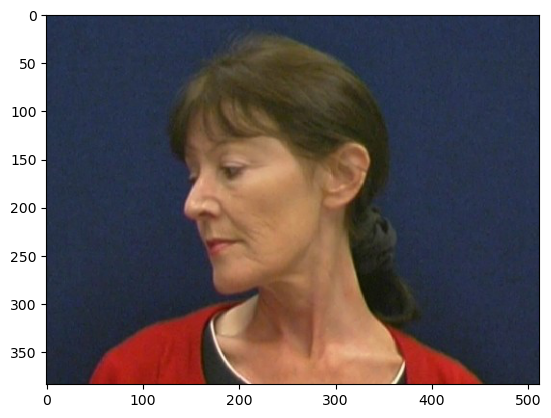

In [24]:
grnd_truth = "fadg0"
img_path = f"{directory}/{grnd_truth}/video/head2/035"
img = Image.open(img_path)
plt.imshow(img)
print(img.size)

In [25]:
correct_detection_count = 0
for label in labels:
    
    # Extract Embedding for ground truth
    try:
        img_path = f"{directory}/{label}/video/head2/025"
        img = Image.open(img_path)
        img_cropped = mtcnn(img)
        img_embedding = resnet(img_cropped.unsqueeze(0))
        
        max_cos = torch.tensor([-1])
        closest_label = None
        
        for test_label, test_embedding in embeddings.items():
            cos_similarity = F.cosine_similarity(img_embedding, test_embedding)
            max_cos = torch.max(max_cos, cos_similarity)
            if max_cos == cos_similarity:
                closest_label = test_label
            
        if closest_label == label:
            correct_detection_count += 1
    except:
        print(label, " Error ")

accuracy = correct_detection_count/ 43
print("-"*50)
print("-"*50)
print("Accuracy is :" , accuracy*100 , "%" )  
print("-"*50)
print("-"*50) 
    

--------------------------------------------------
--------------------------------------------------
Accuracy is : 100.0 %
--------------------------------------------------
--------------------------------------------------


## Accuracy with side face view 

(512, 384)


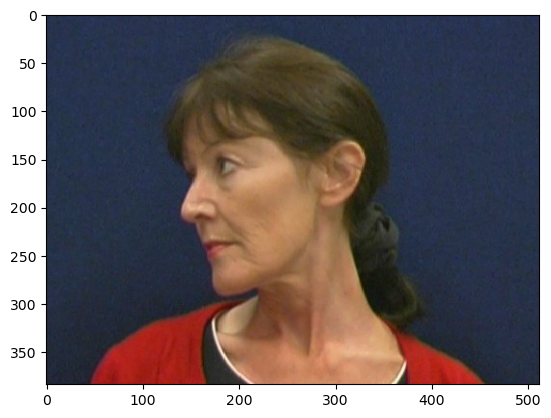

In [26]:
grnd_truth = "fadg0"
img_path = f"{directory}/{grnd_truth}/video/head2/075"
img = Image.open(img_path)
plt.imshow(img)
print(img.size)

In [27]:
correct_detection_count = 0
for label in labels:
    
    # Extract Embedding for ground truth
    try:
        img_path = f"{directory}/{label}/video/head2/075"
        img = Image.open(img_path)
        img_cropped = mtcnn(img)
        img_embedding = resnet(img_cropped.unsqueeze(0))
        
        max_cos = torch.tensor([-1])
        closest_label = None
        
        for test_label, test_embedding in embeddings.items():
            cos_similarity = F.cosine_similarity(img_embedding, test_embedding)
            max_cos = torch.max(max_cos, cos_similarity)
            if max_cos == cos_similarity:
                closest_label = test_label
            
        if closest_label == label:
            correct_detection_count += 1
    except:
        pass
        #print(label, " Error ")

accuracy = correct_detection_count/ 43
print("-"*50)
print("-"*50)
print("Accuracy is :" , accuracy*100 , "%" )  
print("-"*50)
print("-"*50) 
    

--------------------------------------------------
--------------------------------------------------
Accuracy is : 97.67441860465115 %
--------------------------------------------------
--------------------------------------------------


In [28]:
correct_detection_count = 0
for label in labels:
    
    # Extract Embedding for ground truth
    try:
        img_path = f"{directory}/{label}/video/head2/075"
        
        image = cv2.imread(img_path)
        #img_crop = mtcnn(image)
        faces = app.get(image)
        img_embedding = handler.get(image, faces[0])

        closest_label = None
        
        detected_p = None
        accu = -1
        for key, value in arc_embeddings.items():
            recog = handler.compute_sim(value, img_embedding )
            if recog > accu:
                detected_p = key
                accu = recog
        closest_label = detected_p
        
        if closest_label == label:
            correct_detection_count += 1
    except:
        print(label, " Error ")

accuracy = correct_detection_count/ 43
print("-"*50)
print("-"*50)
print("Accuracy is :" , accuracy*100 , "%" )  
print("-"*50)
print("-"*50) 

--------------------------------------------------
--------------------------------------------------
Accuracy is : 100.0 %
--------------------------------------------------
--------------------------------------------------


## Observation

As pose changes accuracy of model decreases 